# Data Challenge 1: Breast Cancer Cell Detection
Susan Currie Sivek

The assigned task is to develop a model that predicts whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell. 

The data provided are for 699 cells. Each has an ID number and an indicator for benign/malignant status. The following characteristics are also included and are each rated 1-10: clump thickness, uniformity of cell size, uniformity of cell shape, marginal adhesion, single epithelial cell size, bare nuclei, bland chromatin, normal nucleoli, and mitoses.

## Import and prepare data for exploration and analysis

I'll read in the data CSV file provided and rename the columns, then verify everything looks OK and do the necessary cleanup.

In [33]:
# import necessary stuff

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

np.random.seed(42) 

In [34]:
# read in data provided in CSV file
df = pd.read_csv("/Users/ssivek/Insight_Projects/data_c/week6/data_challenge_1/breast-cancer-wisconsin.csv", header=None)

In [35]:
df.head() # look at first five rows

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [36]:
# name columns for easier reading
df.columns = ['id', 'clump_thickness', 'uniformity_size', 'uniformity_shape', 'marginal_adhesion', 'single_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses', 'benign_malignant']

In [37]:
df.set_index(['id'], inplace = True)

In [38]:
df.head() # check the renaming

,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,single_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,benign_malignant
id,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


In [39]:
df.shape # I have the right number of rows and columns

(699, 10)

In [40]:
df.info() # check data types

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 1000025 to 897471
Data columns (total 10 columns):
clump_thickness      699 non-null int64
uniformity_size      699 non-null int64
uniformity_shape     699 non-null int64
marginal_adhesion    699 non-null int64
single_cell_size     699 non-null int64
bare_nuclei          699 non-null object
bland_chromatin      699 non-null int64
normal_nucleoli      699 non-null int64
mitoses              699 non-null int64
benign_malignant     699 non-null int64
dtypes: int64(9), object(1)
memory usage: 60.1+ KB


I see that bare_nuclei is not an integer like the other features due to missing data. The bare_nuclei column shows up as an object instead of an integer because there are rows that have a '?' as their value.

In [41]:
df.loc[~df['bare_nuclei'].astype(str).str.isdigit()] # locate rows with '?' for bare_nuclei

,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,single_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,benign_malignant
id,,,,,,,,,,
1057013,8,4,5,1,2,?,7,3,1,4
1096800,6,6,6,9,6,?,7,8,1,2
1183246,1,1,1,1,1,?,2,1,1,2
1184840,1,1,3,1,2,?,2,1,1,2
1193683,1,1,2,1,3,?,1,1,1,2
1197510,5,1,1,1,2,?,3,1,1,2
1241232,3,1,4,1,2,?,3,1,1,2
169356,3,1,1,1,2,?,3,1,1,2
432809,3,1,3,1,2,?,2,1,1,2


These rows are only about 2% of my entire dataset. Because I don't know the reason for these missing values, I will not impute values for them. I'll drop the rows with missing data and convert the bare_nuclei column to integer format. I'll also convert my categorical benign_malignant target variable to the category data type.

In [42]:
# convert bare_nuclei to integer format with NaN for '?'
df['bare_nuclei'] = pd.to_numeric(df['bare_nuclei'], errors='coerce') 

In [43]:
df.dropna(how='any', axis=0, inplace=True) # delete rows with missing values for bare_nuclei

In [44]:
df.bare_nuclei = df.bare_nuclei.astype(np.int64) # conversion to integer
df.benign_malignant = df.benign_malignant.replace(2, 0)
df.benign_malignant = df.benign_malignant.replace(4, 1)
df.info() # conversions and deletions successful; now 683 rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 1000025 to 897471
Data columns (total 10 columns):
clump_thickness      683 non-null int64
uniformity_size      683 non-null int64
uniformity_shape     683 non-null int64
marginal_adhesion    683 non-null int64
single_cell_size     683 non-null int64
bare_nuclei          683 non-null int64
bland_chromatin      683 non-null int64
normal_nucleoli      683 non-null int64
mitoses              683 non-null int64
benign_malignant     683 non-null int64
dtypes: int64(10)
memory usage: 58.7 KB


In [45]:
df.head() # good to go

,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,single_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,benign_malignant
id,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,0
1002945,5,4,4,5,7,10,3,2,1,0
1015425,3,1,1,1,2,2,3,1,1,0
1016277,6,8,8,1,3,4,3,7,1,0
1017023,4,1,1,3,2,1,3,1,1,0


In [46]:
work = df # keep df as a clean copy to reuse later

## Data Visualization and Exploration

I'll first create some basic visualizations of the data and look for trends and correlations among the features.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20f8ccf8>,
      dtype=object)

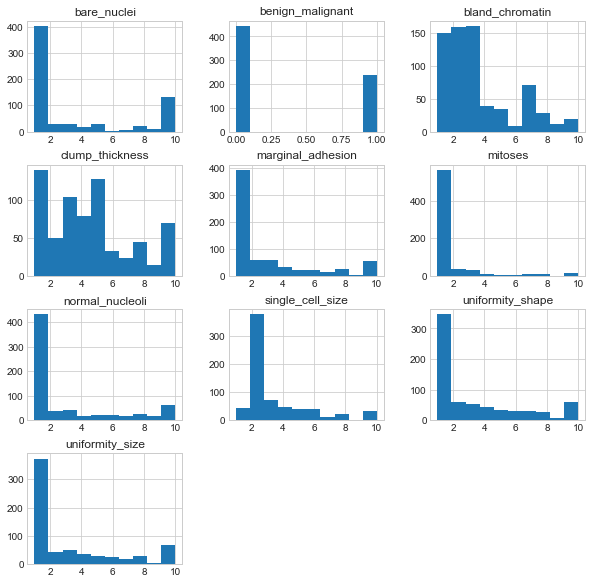

In [47]:
work.hist(figsize=(10,10)) # histograms for all features (ignore id)

I see from these histograms that there are perhaps twice as many benign samples in the dataset as malignant. Many of the features are strongly right skewed. There is more variation in bland chromatin and clump thickness. If I had more time to work on this data challenge, I would probably consider some sort of oversampling strategy to help alleviate the imbalances here.

In [48]:
work.describe() # get basic info on all features

,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,single_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,benign_malignant
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,0.349927
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.477296
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [49]:
corr = work.corr() # correlation matrix for all variables 
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,single_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,benign_malignant
clump_thickness,1,0.64,0.65,0.49,0.52,0.59,0.55,0.53,0.35,0.71
uniformity_size,0.64,1,0.91,0.71,0.75,0.69,0.76,0.72,0.46,0.82
uniformity_shape,0.65,0.91,1,0.69,0.72,0.71,0.74,0.72,0.44,0.82
marginal_adhesion,0.49,0.71,0.69,1,0.59,0.67,0.67,0.6,0.42,0.71
single_cell_size,0.52,0.75,0.72,0.59,1,0.59,0.62,0.63,0.48,0.69
bare_nuclei,0.59,0.69,0.71,0.67,0.59,1,0.68,0.58,0.34,0.82
bland_chromatin,0.55,0.76,0.74,0.67,0.62,0.68,1,0.67,0.35,0.76
normal_nucleoli,0.53,0.72,0.72,0.6,0.63,0.58,0.67,1,0.43,0.72
mitoses,0.35,0.46,0.44,0.42,0.48,0.34,0.35,0.43,1,0.42
benign_malignant,0.71,0.82,0.82,0.71,0.69,0.82,0.76,0.72,0.42,1


The correlation matrix shows that, with the exception of mitoses, many of these features are also correlated fairly strongly with each other. I will have to keep this in mind as I choose my modeling approach.

# Model Options

Which model should I choose for the task of classifying the samples as benign or malignant? I have many supervised learning options for this binary classification task. Logistic correlation might normally have been a good first step, but the correlations among the features suggest it's not a good choice here. I'll instead move first to tree-based models.

As I choose among these models, I will be considering:
- Simplicity: which models use fewer features
- Interpretability: how easy is it to understand and communicate the model
- Accuracy and recall: overall accuracy is important, but for the task of cancer detection, I also want to minimize false negatives so that any potential case of cancer can be identified through this biopsy for further investigation. I will therefore prioritize recall as the key metric of my model's success.

## Model Option 1: Decision Tree Classifier

I'll try using a decision tree to see if my results differ from the logistic regression.

In [50]:
dt_df = df

In [51]:
from sklearn.tree import DecisionTreeClassifier # import decision tree classifier

In [52]:
feature_cols = ['clump_thickness', 'uniformity_size', 'uniformity_shape',
       'marginal_adhesion', 'single_cell_size', 'bare_nuclei',
       'bland_chromatin', 'normal_nucleoli', 'mitoses']
X = dt_df[feature_cols] # features for model
y = dt_df.benign_malignant # target

In [53]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test

In [54]:
# create decision tree classifier
# I have tinkered with different max_depth, splitter, and min_samples_split parameter values to improve metrics
dec_tree = DecisionTreeClassifier(criterion="entropy", max_depth=4, splitter="random", min_samples_split=8)

dec_tree = dec_tree.fit(X_train,y_train) # train classifier

y_pred = dec_tree.predict(X_test) # generate predictions

In [55]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) # get some important metrics

Accuracy: 0.9781021897810219
Precision: 0.9782608695652174
Recall: 0.9574468085106383


In [56]:
scores = cross_val_score(dec_tree, X, y, cv=10, scoring='accuracy') # use k-fold cross-validation to assess model, 10 folds

def display_scores(scores):
        print("Scores:", scores)
        print("Mean:", scores.mean())
        print("Standard deviation:", scores.std())
        
display_scores(scores)

Scores: [0.85507246 0.94202899 0.94202899 0.94202899 0.98529412 0.95588235
 0.95588235 0.98529412 0.95588235 0.98507463]
Mean: 0.9504469341273174
Standard deviation: 0.03609049183532108


In [57]:
scores = cross_val_score(dec_tree, X, y, cv=10, scoring='precision') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.88461538 1.         0.85185185 0.85185185 0.92307692 0.95652174
 1.         0.96       0.88888889 0.95833333]
Mean: 0.9275139972748668
Standard deviation: 0.05306266127065168


In [58]:
scores = cross_val_score(dec_tree, X, y, cv=10, scoring='recall') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.91666667 0.70833333 0.79166667 0.95833333 1.         0.79166667
 0.95833333 0.91666667 1.         1.        ]
Mean: 0.9041666666666666
Standard deviation: 0.09868932735272509


After tuning the parameters, the decision tree achieves a mean accuracy of 94.6%, mean precision of 92.6%, and mean recall of 91.2% in 10-fold cross-validation. 

## Model Option 2: Random Forest Classifier

A random forest classifier may improve even further on the decision tree's results with similar advantages.

In [59]:
from sklearn.ensemble import RandomForestClassifier # import necessary stuff

In [60]:
rf_df = df # fresh version of data

In [61]:
feature_cols = ['clump_thickness', 'uniformity_size', 'uniformity_shape',
       'marginal_adhesion', 'single_cell_size', 'bare_nuclei',
       'bland_chromatin', 'normal_nucleoli', 'mitoses']
X = rf_df[feature_cols] # features for model
y = rf_df.benign_malignant # target

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% training and 20% test

In [62]:
#Create a Gaussian Classifier
rand_for = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets 
rand_for.fit(X_train,y_train)

y_pred = rand_for.predict(X_test)

In [63]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) # get some important metrics

Accuracy: 0.9708029197080292
Precision: 0.9791666666666666
Recall: 0.94


In [64]:
scores = cross_val_score(rand_for, X, y, cv=10, scoring='accuracy') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.92753623 0.95652174 0.95652174 0.94202899 0.98529412 0.98529412
 0.98529412 0.98529412 0.98529412 0.98507463]
Mean: 0.969415391075314
Standard deviation: 0.020838073708228946


In [65]:
scores = cross_val_score(rand_for, X, y, cv=10, scoring='precision') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.91304348 1.         0.88888889 0.88461538 0.96       0.95652174
 1.         1.         1.         1.        ]
Mean: 0.9603069490895578
Standard deviation: 0.0457773977146163


In [66]:
scores = cross_val_score(rand_for, X, y, cv=10, scoring='recall') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.875      0.91666667 1.         0.95833333 1.         0.95833333
 0.95833333 0.95833333 0.95833333 1.        ]
Mean: 0.9583333333333334
Standard deviation: 0.0372677996249965


The random forest classifier shows some improvement over the decision tree classifier in terms of accuracy, precision, and recall. I'll now look at the feature importance to see which features stand out and whether I might want to try simplifying the model at all.

In [67]:
feature_imp = pd.Series(rand_for.feature_importances_,index=feature_cols).sort_values(ascending=False)
feature_imp

uniformity_size      0.256986
uniformity_shape     0.235849
bare_nuclei          0.208512
bland_chromatin      0.093120
normal_nucleoli      0.063704
single_cell_size     0.053180
clump_thickness      0.042366
marginal_adhesion    0.040703
mitoses              0.005581
dtype: float64

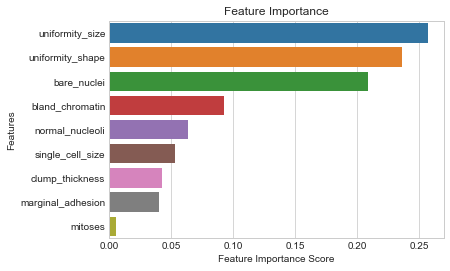

In [68]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.show()

Three features clearly lead the pack (uniformity_size, uniformity_shape, and bare_nuclei), with a group of three features following them (normal_nucleoli, bland_chromatin, and single_cell_size). I'll try redoing the random forest classifier with smaller sets of features to strive for greater simplicity while retaining high accuracy, precision, and recall.

## Model Option 3: Reduced random forest classifier with 6 most important features

First I'll try a random forest classifier with the top 6 features from the full random forest model above.

In [69]:
reduced_features = ['uniformity_size', 'uniformity_shape', 'single_cell_size', 'bare_nuclei',
       'bland_chromatin', 'normal_nucleoli']
X_red = rf_df[reduced_features] # features for model
y_red = rf_df.benign_malignant # target

X_train, X_test, y_train, y_test = train_test_split(X_red, y_red, test_size=0.2) # 80% training and 20% test sets

In [70]:
rand_for_red = RandomForestClassifier(n_estimators=100) #Create a Gaussian Classifie

rand_for_red.fit(X_train,y_train) # train the model

y_pred = rand_for_red.predict(X_test) # make predictions using the model

In [71]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) # get some important metrics

Accuracy: 0.9781021897810219
Precision: 0.9736842105263158
Recall: 0.9487179487179487


In [72]:
scores = cross_val_score(rand_for_red, X, y, cv=10, scoring='accuracy') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.91304348 0.97101449 0.95652174 0.94202899 0.98529412 0.97058824
 0.97058824 0.98529412 0.98529412 0.98507463]
Mean: 0.9664742146047256
Standard deviation: 0.022393013700531123


In [73]:
scores = cross_val_score(rand_for_red, X, y, cv=10, scoring='precision') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.91666667 1.         0.88888889 0.88461538 0.96       0.96
 1.         1.         1.         0.95833333]
Mean: 0.9568504273504275
Standard deviation: 0.04349826184682486


In [74]:
scores = cross_val_score(rand_for_red, X, y, cv=10, scoring='recall') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.875      0.875      1.         0.95833333 1.         1.
 0.91666667 0.95833333 0.95833333 1.        ]
Mean: 0.9541666666666668
Standard deviation: 0.047324236215002285


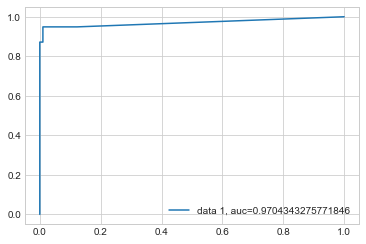

In [75]:
y_pred_proba = rand_for_red.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show() # show the ROC curve and the AUC

The 6-feature random forest classifier performs about the same as the full random forest model, with just slightly lower accuracy, precision, and recall. 

I'll now try out a model with just the top three features, just to see if I could make things super simple.

## Model Option 4: An even more reduced random forest classifer with 3 features

This model will include only uniformity_size, uniformity_shape, and single_cell_size as its sole features. Simple models are great if they can provide similar levels of utility. Let's see how this one does.

In [76]:
few_features = ['uniformity_size', 'uniformity_shape', 'bare_nuclei'] # top 3 from feature ranking above
X_few = rf_df[reduced_features] # features for model
y_few = rf_df.benign_malignant # target

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_few, y_few, test_size=0.2) # 80% training and 20% test

In [77]:
rand_for_few = RandomForestClassifier(n_estimators=100) # create a Gaussian classifier

rand_for_few.fit(X_train,y_train) # train the model

y_pred = rand_for_few.predict(X_test) # generate predictions

In [78]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) # get some important metrics

Accuracy: 0.9416058394160584
Precision: 0.8771929824561403
Recall: 0.9803921568627451


In [79]:
scores = cross_val_score(rand_for_red, X, y, cv=10, scoring='accuracy') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.92753623 0.98550725 0.95652174 0.94202899 0.97058824 0.97058824
 0.98529412 0.98529412 0.98529412 0.98507463]
Mean: 0.9693727653293636
Standard deviation: 0.019832850898862185


In [80]:
scores = cross_val_score(rand_for_red, X, y, cv=10, scoring='precision') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.91666667 1.         0.88888889 0.88461538 0.96       0.95833333
 1.         1.         1.         0.95833333]
Mean: 0.9566837606837607
Standard deviation: 0.04348906674263178


In [81]:
scores = cross_val_score(rand_for_red, X, y, cv=10, scoring='recall') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.91666667 0.875      1.         0.95833333 1.         0.95833333
 0.875      0.95833333 0.95833333 1.        ]
Mean: 0.95
Standard deviation: 0.044876373392787536


Lowering the number of features in the random forest classifier increased accuracy slightly, but precision and recall are still lower than either the top-6-features or the full random forest model. As stated above, maximizing recall is a high priority for this task, so the full random forest classifier is still the winner so far.

# Model Option 5: Getting fancy with gradient boosting

_Confession: I am out of time. But I'll just try a gradient boosting model for the heck of it, and because I am actually having fun. If I stopped here, I'd go with Option 2, the full random forest classifier, shown above._

Gradient boosting models can sometimes provide even greater levels of accuracy for datasets like this one where there is a high level of imbalance in the classification (i.e., in this case, benign/malignant status). This approach can be a bit slower to train because of the way it is constructed. I'll try it with just the top three features identified above.

In [82]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier

In [83]:
gb_df = df

In [84]:
reduced_features = ['uniformity_size', 'uniformity_shape', 'bare_nuclei']
X_few = gb_df[reduced_features] # features for model
y_few = gb_df.benign_malignant # target

X_train, X_test, y_train, y_test = train_test_split(X_few, y_few, test_size=0.2) # 80% training and 20% test

In [85]:
# gradient boosting models require more tuning
# I have tinkered with the N_estimators, min_samples_split, and min_samples_leaf parameters here
gb = GradientBoostingClassifier(n_estimators=80, learning_rate=1.0, 
                                max_depth=5, random_state=0, min_samples_split=12, 
                                min_samples_leaf=15).fit(X_train, y_train) # fit model

y_pred = gb.predict(X_test) # make predictions

In [86]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) # get some important metrics

Accuracy: 0.9562043795620438
Precision: 0.92
Recall: 0.9583333333333334


In [87]:
scores = cross_val_score(gb, X, y, cv=10, scoring='accuracy') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.92753623 0.95652174 0.95652174 0.94202899 0.97058824 0.97058824
 0.95588235 1.         0.98529412 1.        ]
Mean: 0.9664961636828645
Standard deviation: 0.02249448294965619


In [88]:
scores = cross_val_score(gb, X, y, cv=10, scoring='precision') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.88       1.         0.88888889 0.88461538 0.95833333 0.92307692
 1.         1.         1.         1.        ]
Mean: 0.9534914529914531
Standard deviation: 0.05107064705460835


In [89]:
scores = cross_val_score(gb, X, y, cv=10, scoring='recall') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.91666667 0.875      1.         0.95833333 0.95833333 1.
 0.875      1.         0.95833333 1.        ]
Mean: 0.9541666666666668
Standard deviation: 0.047324236215002285


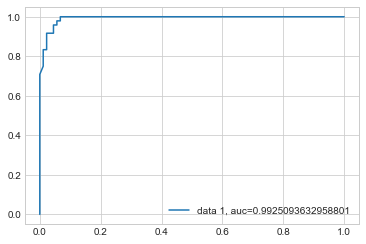

In [90]:
y_pred_proba = gb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show() # show the ROC curve and the AUC

This model does not show a dramatic improvement beyond any of the random forest models shown above. All metrics are lower than my previously preferred Option 2, the full random forest classifier.

# Model Option 6: Naive Bayes Classifier (Top 3 Features)

Again, out of time, but curious to see whether Naive Bayes would work here. This should be a good model for this dataset, as it would not be affected by its multicollinearity, and it should also work well with the high number of predictive features. I'll try it with just the top three features identified above.

In [91]:
nb_df = df

In [92]:
from sklearn.naive_bayes import GaussianNB

In [93]:
reduced_features = ['uniformity_size', 'uniformity_shape', 'bare_nuclei']
X_few = nb_df[reduced_features] # features for model
y_few = nb_df.benign_malignant # target

X_train, X_test, y_train, y_test = train_test_split(X_few, y_few, test_size=0.2) # 80% training and 20% test

nb = GaussianNB() # fit model
y_pred = nb.fit(X_train, y_train).predict(X_test)

In [94]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) # get some important metrics

Accuracy: 0.9635036496350365
Precision: 0.9166666666666666
Recall: 0.9777777777777777


In [95]:
scores = cross_val_score(nb, X_few, y_few, cv=10, scoring='accuracy') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.94202899 0.92753623 0.95652174 0.94202899 0.97058824 0.95588235
 0.98529412 0.98529412 0.98529412 0.98507463]
Mean: 0.9635543510071127
Standard deviation: 0.02064644030085901


In [96]:
scores = cross_val_score(nb, X_few, y_few, cv=10, scoring='precision') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.88461538 1.         0.88888889 0.88461538 0.92307692 0.92
 1.         0.96       1.         0.95833333]
Mean: 0.9419529914529916
Standard deviation: 0.04575108393154945


In [97]:
scores = cross_val_score(nb, X_few, y_few, cv=10, scoring='recall') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.95833333 0.79166667 1.         0.95833333 1.         0.95833333
 0.95833333 1.         0.95833333 1.        ]
Mean: 0.9583333333333334
Standard deviation: 0.05892556509887897


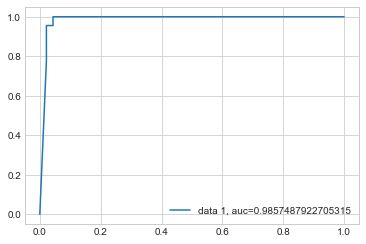

In [98]:
y_pred_proba = nb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show() # show the ROC curve and the AUC

This simple Naive Bayes classifier's accuracy and precision are a smidge lower than the Option 2 full random forest classifier, but its recall is tied for highest of any of the models, which is significant for this task. Let's see how it does with all the available features instead of just three.

## Model Option 7: Naive Bayes with All Features

My last model attempt will be a Naive Bayes classifier with all the available features from the dataset. This will show if the simpler Naive Bayes approach above could be improved upon still further with more information for the prediction.

In [99]:
feature_cols = ['clump_thickness', 'uniformity_size', 'uniformity_shape',
       'marginal_adhesion', 'single_cell_size', 'bare_nuclei',
       'bland_chromatin', 'normal_nucleoli', 'mitoses'] # include all the features
X = nb_df[feature_cols] # features for model
y = nb_df.benign_malignant # target

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% training and 20% test

gnb_full = GaussianNB()
y_pred = gnb_full.fit(X_train, y_train).predict(X_test)

In [100]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) # get some important metrics

Accuracy: 0.9854014598540146
Precision: 0.9782608695652174
Recall: 0.9782608695652174


In [101]:
scores = cross_val_score(gnb_full, X, y, cv=10, scoring='accuracy') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.92753623 0.95652174 0.94202899 0.94202899 0.98529412 0.95588235
 0.97058824 0.97058824 0.98529412 0.97014925]
Mean: 0.9605912254583858
Standard deviation: 0.01825426630766469


In [102]:
scores = cross_val_score(gnb_full, X, y, cv=10, scoring='precision') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.85185185 0.88888889 0.85714286 0.88461538 0.96       0.92
 0.95833333 0.95833333 1.         0.92      ]
Mean: 0.9199165649165648
Standard deviation: 0.046641164243002874


In [103]:
scores = cross_val_score(gnb_full, X, y, cv=10, scoring='recall') # use k-fold cross-validation to assess model, 10 folds
display_scores(scores)

Scores: [0.95833333 1.         1.         0.95833333 1.         0.95833333
 0.95833333 0.95833333 0.95833333 1.        ]
Mean: 0.975
Standard deviation: 0.02041241452319313


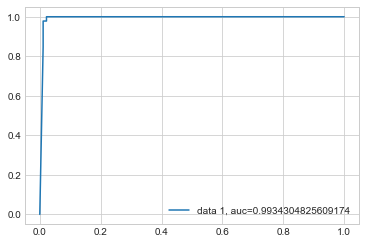

In [104]:
y_pred_proba = gnb_full.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show() # show the ROC curve and the AUC

This Naive Bayes classifier using all the features in the dataset has the highest recall of any model tested, and its accuracy is comparable to the previous leader of the model pack, the full random forest classifier (Option 2). Its precision is a bit lower, but that metric is of lower priority than recall and accuracy for this task. Therefore, this model appears to be the winner among the seven models constructed here.

# Recommendations and Next Steps

As noted above, I would recommend that for this specific task, the diagnostician use Option 7 above, the Naive Bayes classifier including all available features in the dataset.

To further explore these data and develop useful models for prediction, I would consider an oversampling strategy like SMOTE to better balance the data. I would also try a basic neural network to see if I could beat my chosen classifier here. I would try to gain better subject matter knowledge to understand whether the features in the dataset could be logically and reasonably combined to improve the modeling approach.